In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
import scipy.io
import numpy as np
import torchvision

from curriculum_deeplab.data_parameters import DataParamMode, DataParamOptim
from curriculum_deeplab.data_parameters import DataParameterManager

In [2]:
torchvision.datasets.MNIST(root="../data", download=True)

/share/data_supergrover1/weihsbach/shared_data/tmp/curriculum_deeplab/.venv/lib/python3.9/site-packages/torchvision/datasets/mnist.py:498: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  ../torch/csrc/utils/tensor_numpy.cpp:180.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


Dataset MNIST
    Number of datapoints: 60000
    Root location: ../data
    Split: Train

In [3]:
class dotdict(dict):
    """dot.notation access to dictionary attributes"""
    __getattr__ = dict.get
    __setattr__ = dict.__setitem__
    __delattr__ = dict.__delitem__
    
config = dotdict({
    # Data parameter config
    'data_param_mode': DataParamMode.ONLY_INSTANCE_PARAMS,
    'init_class_param': 1.0, 
    'lr_class_param': 0.1,
    'init_inst_param': 1.0, 
    'lr_inst_param': 0.1,
    'wd_inst_param': 0.0,
    'wd_class_param': 0.0,
    
    'skip_clamp_data_param': False,
    'clamp_sigma_min': np.log(1/20),
    'clamp_sigma_max': np.log(20),
    'optim_algorithm': DataParamOptim.ADAM,
    'optim_options': dict(
        # momentum=.9
        betas=(0.9, 0.999)
    )
})

torch.Size([958, 28, 28])


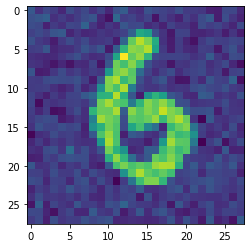

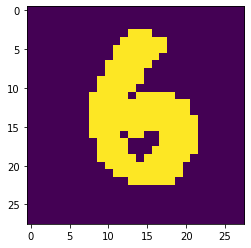

In [4]:
data = torch.from_numpy(scipy.io.loadmat('../data/mnist-six.mat')['data']).float()
segment_untouched = (data>150).long()
segment = (data>150).long()
segment2 = (data>5).long()


image = (data/255 + torch.randn_like(data)*.1).unsqueeze(1)
print(data.shape)
plt.imshow(image[152,0].data.cpu())
plt.show()
plt.imshow(segment2[152].cpu())

In [5]:
do_flip = torch.rand(800)>0.7#[::2]
# do_flip = torch.rand(800)>0.0#[::2]
idx_flip = torch.empty(0).long()
idx_clean = torch.empty(0).long()
for i in range(800):
    if(do_flip[i]):
        idx_flip = torch.cat((idx_flip,torch.tensor([i])))
        segment[i] = torch.roll(segment2[i].transpose(-2,-1),(int(torch.randn(1)*5),int(torch.randn(1)*5)),(0,1))
    else:
        idx_clean = torch.cat((idx_clean,torch.tensor([i])))

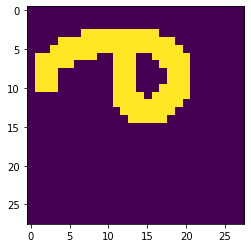

tensor([0, 1])


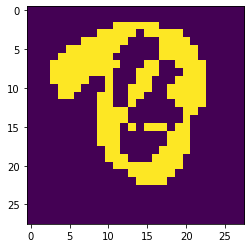

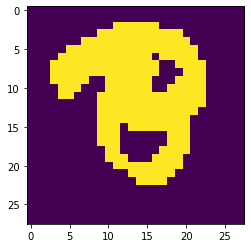

In [8]:
plt.imshow(segment[idx_flip[0]].cpu())
plt.show()
print(segment[0].unique())


x_or_intersect = torch.logical_xor(segment, segment_untouched)
or_intersect = torch.logical_or(segment, segment_untouched)
plt.imshow(x_or_intersect[152].cpu())
plt.show()
plt.imshow(or_intersect[152].cpu())
plt.show()

In [9]:
net = nn.Sequential(nn.Conv2d(1,32,3,padding=1),nn.BatchNorm2d(32),nn.ReLU(),\
                   nn.Conv2d(32,32,3,padding=1),nn.BatchNorm2d(32),nn.ReLU(),\
                   nn.Conv2d(32,32,3,padding=1),nn.BatchNorm2d(32),nn.ReLU(),\
                   nn.Conv2d(32,2,3,padding=1))


embedding = nn.Embedding(800, 1, sparse=True)
embedding

# torch.nn.init.constant_(embedding.weight.data, 1.)

run_loss_mattias = torch.zeros(500)
run_cc_mattias = torch.zeros(500)

net = net.cuda()
embedding = embedding.cuda()
image = image.cuda()
segment = segment.cuda()
run_loss_mattias = run_loss_mattias.cuda()
run_cc_mattias = run_cc_mattias.cuda()
do_flip = do_flip.cuda()


optimizer = torch.optim.Adam(net.parameters(), lr=0.0001, betas=(0.9, 0.999), eps=1e-08)
optimizer_data = torch.optim.SparseAdam(embedding.parameters(), lr=0.1, betas=(0.9, 0.999), eps=1e-08)

for i in range(500):
    if i % 50 == 0:
        print(i)
    idx = torch.randperm(800)[:64]
    idx = idx.cuda()
    optimizer.zero_grad()
    optimizer_data.zero_grad()

    input = image[idx]
    output = net(input)

    loss_mattias = nn.CrossEntropyLoss(reduction='none')(output,segment[idx]).mean(-1).mean(-1)
    
    run_cc_mattias[i] = np.corrcoef(torch.sigmoid(embedding.weight).cpu().data.squeeze().numpy(),do_flip.float().cpu().numpy())[0,1]
    run_loss_mattias[i] = (loss_mattias*(1-do_flip[idx].float())).mean().item()

    # print(loss)
    weight = torch.sigmoid(embedding(idx)).squeeze()
    weight = weight/weight.mean()
    
    (loss_mattias*weight).sum().backward()
    optimizer.step()
    optimizer_data.step()

0
50
100
150
200
250
300
350
400
450


In [10]:
# Setup data parameter manager
CLASSES = ['background', 'six']
dpm = DataParameterManager(instance_keys=range(800), class_keys=CLASSES, config=config, device='cuda')

net2 = nn.Sequential(nn.Conv2d(1,32,3,padding=1),nn.BatchNorm2d(32),nn.ReLU(),\
                   nn.Conv2d(32,32,3,padding=1),nn.BatchNorm2d(32),nn.ReLU(),\
                   nn.Conv2d(32,32,3,padding=1),nn.BatchNorm2d(32),nn.ReLU(),\
                   nn.Conv2d(32,2,3,padding=1))

optimizer2 = torch.optim.Adam(net2.parameters(), lr=0.0001, betas=(0.9, 0.999), eps=1e-08)

run_loss2 = torch.zeros(500)
run_cc2 = torch.zeros(500)

image = image.cuda()
segment = segment.cuda()
net2 = net2.cuda()
run_loss2 = run_loss2.cuda()
run_cc2 = run_cc2.cuda()
do_flip = do_flip.cuda()

for i in range(500):
    if i % 50 == 0:
        print(i)
    idx = torch.randperm(800)[:64]
    idx = idx.cuda()

    optimizer2.zero_grad()

    # Alt impl
    _input = image[idx]
    logits2 = net2(_input)
    logits2 = logits2.permute(0,2,3,1)
    _, loss = dpm.do_basic_train_step(
        nn.BCEWithLogitsLoss(), 
        logits2, 
        torch.nn.functional.one_hot(segment[idx].long()), 
        optimizer2, 
        inst_keys=idx.tolist(),
        scaler=None)

    run_cc2[i] = torch.tensor(np.corrcoef(torch.sigmoid(dpm.get_parameter_tensor(inst_keys=range(800))).detach().cpu().numpy(), do_flip.float().cpu().numpy()))[0,1]
    run_loss2[i] = (loss*(1-do_flip[idx].float())).mean().item()

Initialized instance data parameters with: 1.0
0
50
100
150
200
250
300
350
400
450


In [45]:
import torch.cuda.amp as amp

net3 = nn.Sequential(nn.Conv2d(1,32,3,padding=1),nn.BatchNorm2d(32),nn.ReLU(),\
                   nn.Conv2d(32,32,3,padding=1),nn.BatchNorm2d(32),nn.ReLU(),\
                   nn.Conv2d(32,32,3,padding=1),nn.BatchNorm2d(32),nn.ReLU(),\
                   nn.Conv2d(32,2,3,padding=1))


embedding3 = nn.Embedding(800, 1, sparse=True)
torch.nn.init.constant_(embedding3.weight.data, +1.)
# embedding3.weight.data = torch.rand_like(embedding3.weight.data)*1e-4 +1.

run_loss_mattias3 = torch.zeros(500)
run_cc_mattias3 = torch.zeros(500)

net3 = net3.cuda()
embedding3 = embedding3.cuda()
image = image.cuda()
segment = segment.cuda()
run_loss_mattias3 = run_loss_mattias3.cuda()
run_cc_mattias3 = run_cc_mattias3.cuda()
do_flip = do_flip.cuda()


optimizer3 = torch.optim.Adam(net3.parameters(), lr=0.0001, betas=(0.9, 0.999), eps=1e-08)
optimizer_data3 = torch.optim.SparseAdam(embedding3.parameters(), lr=0.1, betas=(0.9, 0.999), eps=1e-08)
scaler = amp.GradScaler()


for i in range(500):
    if i % 50 == 0:
        print(i)
    idx = torch.randperm(800)[:64]
    idx = idx.cuda()
    optimizer3.zero_grad()
    optimizer_data3.zero_grad()

    input = image[idx]
    output = net3(input)

    # Var 0
    # loss_mattias = nn.CrossEntropyLoss(reduction='none')(output,segment[idx]).mean((-1,-2))
    # weight = torch.sigmoid(embedding3(idx)).squeeze()
    # weight = weight/weight.mean()
    # dp_loss = loss_mattias*weight
    # dp_loss.sum().backward()

    # Var 1 working!
    # weight = embedding3(idx).squeeze()
    # dp_logits = output*weight.exp().view(-1,1,1,1)
    # loss_mattias = nn.CrossEntropyLoss(reduction='sum')(
    #     dp_logits,
    #     segment[idx]
    # )
    # dp_loss = loss_mattias
    # dp_loss.sum().backward()

    # Var 1.5
    # weight = embedding3(idx).squeeze()
    # dp_logits = output/torch.sigmoid(weight).view(-1,1,1,1)
    # loss_mattias = nn.CrossEntropyLoss(reduction='sum')(
    #     dp_logits,
    #     segment[idx]
    # )
    # dp_loss = loss_mattias
    # dp_loss.sum().backward()

    # Var 2, with autocast - setting embedding vector to 0 yields best performance
    with amp.autocast(enabled=True):
        loss = nn.CrossEntropyLoss(reduction='none')(output,segment[idx]).mean((-1,-2))
        weight = embedding3(idx)

        weight = torch.sigmoid(weight).squeeze()
        dp_loss = (loss*weight/weight.mean()).sum()

    scaler.scale(dp_loss).backward()
    scaler.step(optimizer3)        
    scaler.step(optimizer_data3)
    scaler.update()
    
    run_cc_mattias3[i] = np.corrcoef(torch.sigmoid(embedding3.weight).cpu().data.squeeze().numpy(),do_flip.float().cpu().numpy())[0,1]
    run_loss_mattias3[i] = (loss*(1-do_flip[idx].float())).mean().item()


0
50
100
150
200
250
300
350
400
450


# Embedding 4

In [134]:
import torch.cuda.amp as amp

net4 = nn.Sequential(nn.Conv2d(1,32,3,padding=1),nn.BatchNorm2d(32),nn.ReLU(),\
                   nn.Conv2d(32,32,3,padding=1),nn.BatchNorm2d(32),nn.ReLU(),\
                   nn.Conv2d(32,32,3,padding=1),nn.BatchNorm2d(32),nn.ReLU(),\
                   nn.Conv2d(32,2,3,padding=1))

GRID_SIZE_Y, GRID_SIZE_X = torch.Size((10,10))



# embedding4 = nn.Embedding(800, GRID_SIZE_Y*GRID_SIZE_X, sparse=True) # works TODO
embedding4 = nn.Embedding(800*GRID_SIZE_Y*GRID_SIZE_X, 1, sparse=True)
torch.nn.init.constant_(embedding4.weight.data, +1.)

run_loss_mattias4 = torch.zeros(500)
run_cc_mattias4 = torch.zeros(500)

net4 = net4.cuda()
embedding4 = embedding4.cuda()
image = image.cuda()
segment = segment.cuda()
x_or_intersect = x_or_intersect.cuda()
or_intersect = or_intersect.cuda()
run_loss_mattias4 = run_loss_mattias4.cuda()
run_cc_mattias4 = run_cc_mattias4.cuda()
do_flip = do_flip.cuda()

optimizer4 = torch.optim.Adam(net4.parameters(), lr=0.0001, betas=(0.9, 0.999), eps=1e-08)
optimizer_data4 = torch.optim.SparseAdam(embedding4.parameters(), lr=0.1, betas=(0.9, 0.999), eps=1e-08)
scaler = amp.GradScaler()

def map_idxs(idxs, grid_size_y, grid_size_x):
    with torch.no_grad():
        t_sz = grid_size_y * grid_size_x
        return ((idxs*t_sz).long().repeat(t_sz).view(t_sz, idxs.numel())+torch.tensor(range(t_sz)).to(idxs).view(t_sz,1)).permute(1,0).reshape(-1)

for i in range(500):
    if i % 50 == 0:
        print(i)
    idx = torch.randperm(800)[:64]
    idx = idx.cuda()
    optimizer4.zero_grad()
    optimizer_data4.zero_grad()

    input = image[idx]
    output = net4(input)

   
    # Var 4, with autocast - setting embedding vector to 0 yields best performance
    with amp.autocast(enabled=True):
        # loss = nn.CrossEntropyLoss(reduction='none')(output,segment[idx]).mean((-1,-2)) #works TODO
        loss = nn.CrossEntropyLoss(reduction='none')(output,segment[idx])
        # weight = embedding4(idx).reshape(-1, GRID_SIZE_Y, GRID_SIZE_X) #works TODO
        # all_idxs = (idx.repeat(4).view(4,64)+torch.tensor(range(4), device='cuda').view(4,1)).permute(1,0).reshape(-1)
        all_idxs = map_idxs(idx, GRID_SIZE_Y, GRID_SIZE_X)
        weight = embedding4(all_idxs)
        weight = weight.reshape(-1, GRID_SIZE_Y, GRID_SIZE_X)
        weight = weight.unsqueeze(1)
        # Corners need to be aligned

        weight = torch.nn.functional.interpolate(weight, size=(segment.shape[-2:]), mode='bilinear', 
            align_corners=True
        ).squeeze(1)
        # weight = torch.sigmoid(weight).sum((-1,-2)) # WORKS TODO
        weight = torch.sigmoid(weight)
        weight = weight/weight.mean()
        dp_loss = (loss*weight).sum()

    scaler.scale(dp_loss).backward()
    scaler.step(optimizer4)        
    scaler.step(optimizer_data4)
    scaler.update()
    # run_cc_mattias4[i] = np.corrcoef(torch.sigmoid(embedding4.weight.sum(dim=-1)).cpu().data.squeeze().numpy(),do_flip.float().cpu().numpy())[0,1] # works TODO

    all_idxs = torch.tensor(list(range(800))).cuda()
    emb_map_idxs = map_idxs(all_idxs, GRID_SIZE_Y, GRID_SIZE_X)

    masks = or_intersect[all_idxs].float()
    masked_weights = torch.nn.functional.interpolate(embedding4(emb_map_idxs).view(-1,1,GRID_SIZE_Y, GRID_SIZE_X), size=(masks.shape[-2:]), mode='bilinear', align_corners=True).squeeze(1) * masks
    masked_weights[masked_weights==0] = float('nan')
    
    # masked_weights = torch.nn.functional.interpolate(or_intersect[:800].unsqueeze(1).float(), size=(GRID_SIZE_Y, GRID_SIZE_Y)).squeeze(1) * embedding4(emb_map_idxs).view(-1,GRID_SIZE_Y, GRID_SIZE_X)
    # masked_weights = masked_weights.view(-1, GRID_SIZE_Y*GRID_SIZE_X)
    run_cc_mattias4[i] = np.corrcoef(
        np.nanmean(masked_weights.detach().cpu(), axis=(-2,-1)),
        do_flip.float().cpu().numpy())[0,1]
    run_loss_mattias4[i] = (loss.mean((-2,-1))*(1-do_flip[idx].float())).mean().item()


0
50
100
150
200
250
300
350
400
450


In [193]:
import torch.cuda.amp as amp

net4 = nn.Sequential(nn.Conv2d(1,32,3,padding=1),nn.BatchNorm2d(32),nn.ReLU(),\
                   nn.Conv2d(32,32,3,padding=1),nn.BatchNorm2d(32),nn.ReLU(),\
                   nn.Conv2d(32,32,3,padding=1),nn.BatchNorm2d(32),nn.ReLU(),\
                   nn.Conv2d(32,2,3,padding=1))

GRID_SIZE_Y, GRID_SIZE_X = torch.Size((10,10))



# embedding4 = nn.Embedding(800, GRID_SIZE_Y*GRID_SIZE_X, sparse=True) # works TODO
embedding4 = nn.Embedding(800*GRID_SIZE_Y*GRID_SIZE_X, 1, sparse=True)
torch.nn.init.constant_(embedding4.weight.data, +1.)

run_loss_mattias4 = torch.zeros(500)
run_cc_mattias4 = torch.zeros(500)

net4 = net4.cuda()
embedding4 = embedding4.cuda()
image = image.cuda()
segment = segment.cuda()
x_or_intersect = x_or_intersect.cuda()
or_intersect = or_intersect.cuda()
run_loss_mattias4 = run_loss_mattias4.cuda()
run_cc_mattias4 = run_cc_mattias4.cuda()
do_flip = do_flip.cuda()

optimizer4 = torch.optim.Adam(net4.parameters(), lr=0.0001, betas=(0.9, 0.999), eps=1e-08)
optimizer_data4 = torch.optim.SparseAdam(embedding4.parameters(), lr=0.1, betas=(0.9, 0.999), eps=1e-08)
scaler = amp.GradScaler()

def map_idxs(idxs, grid_size_y, grid_size_x):
    with torch.no_grad():
        t_sz = grid_size_y * grid_size_x
        return ((idxs*t_sz).long().repeat(t_sz).view(t_sz, idxs.numel())+torch.tensor(range(t_sz)).to(idxs).view(t_sz,1)).permute(1,0).reshape(-1)

for i in range(500):
    if i % 50 == 0:
        print(i)
    idx = torch.randperm(800)[:64]
    idx = idx.cuda()
    optimizer4.zero_grad()
    optimizer_data4.zero_grad()

    input = image[idx]
    output = net4(input)

   
    # Var 4, with autocast - setting embedding vector to 0 yields best performance
    with amp.autocast(enabled=True):
        # loss = nn.CrossEntropyLoss(reduction='none')(output,segment[idx]).mean((-1,-2)) #works TODO
        # loss = nn.CrossEntropyLoss(reduction='none')(output*weight,segment[idx])
        # weight = embedding4(idx).reshape(-1, GRID_SIZE_Y, GRID_SIZE_X) #works TODO
        # all_idxs = (idx.repeat(4).view(4,64)+torch.tensor(range(4), device='cuda').view(4,1)).permute(1,0).reshape(-1)
        all_idxs = map_idxs(idx, GRID_SIZE_Y, GRID_SIZE_X)
        weight = embedding4(all_idxs)
        weight = weight.reshape(-1, GRID_SIZE_Y, GRID_SIZE_X)
        weight = weight.unsqueeze(1)
        # Corners need to be aligned

        weight = torch.nn.functional.interpolate(weight, size=(segment.shape[-2:]), mode='bilinear', 
            align_corners=True
        )
        # weight = torch.sigmoid(weight).sum((-1,-2)) # WORKS TODO
        weight = torch.sigmoid(weight)
        weight = weight/weight.mean()
        logits = output*weight
        loss = nn.CrossEntropyLoss(reduction='none')(logits,segment[idx])
        # dp_loss = (loss.mean((-1,-2)).view(-1,1,1)*weight).sum()
        dp_loss = loss.mean((-1,-2)).sum() # best so far
        ######
        ######

    scaler.scale(dp_loss).backward()
    scaler.step(optimizer4)        
    scaler.step(optimizer_data4)
    scaler.update()
    # run_cc_mattias4[i] = np.corrcoef(torch.sigmoid(embedding4.weight.sum(dim=-1)).cpu().data.squeeze().numpy(),do_flip.float().cpu().numpy())[0,1] # works TODO

    all_idxs = torch.tensor(list(range(800))).cuda()
    emb_map_idxs = map_idxs(all_idxs, GRID_SIZE_Y, GRID_SIZE_X)

    masks = or_intersect[all_idxs].float()
    masked_weights = torch.nn.functional.interpolate(embedding4(emb_map_idxs).view(-1,1,GRID_SIZE_Y, GRID_SIZE_X), size=(masks.shape[-2:]), mode='bilinear', align_corners=True).squeeze(1) * masks
    masked_weights[masked_weights==0] = float('nan')
    
    # masked_weights = torch.nn.functional.interpolate(or_intersect[:800].unsqueeze(1).float(), size=(GRID_SIZE_Y, GRID_SIZE_Y)).squeeze(1) * embedding4(emb_map_idxs).view(-1,GRID_SIZE_Y, GRID_SIZE_X)
    # masked_weights = masked_weights.view(-1, GRID_SIZE_Y*GRID_SIZE_X)
    run_cc_mattias4[i] = np.corrcoef(
        np.nanmean(masked_weights.detach().cpu(), axis=(-2,-1)),
        do_flip.float().cpu().numpy())[0,1]
    run_loss_mattias4[i] = (loss.mean((-2,-1))*(1-do_flip[idx].float())).mean().item()


0
50
100
150
200
250
300
350
400
450


weights


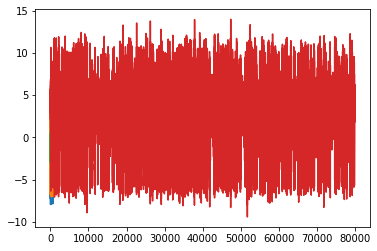

loss


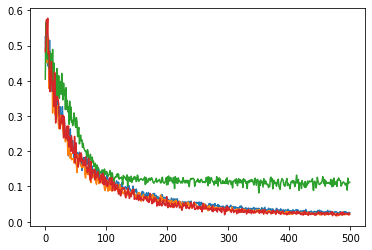

tensor(0.0257)
tensor(0.1122)
tensor(0.0223)
tensor(0.0205)
cc


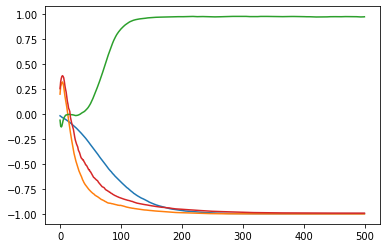

corr_coeff
-0.9971262812614441
-0.9999959468841553
0.9692919850349426
-0.9925280213356018
weight_std
5.1602301597595215
5.559051036834717
1.2514355182647705
3.2198660373687744
params
19586
80000


In [194]:
print("weights")
plt.plot(embedding.weight.data.cpu())
plt.plot(embedding3.weight.data.cpu())
plt.plot(dpm.get_parameter_tensor(inst_keys='all').detach().cpu().numpy())
plt.plot(embedding4.weight.mean(-1).data.cpu())

plt.show()
print("loss")
plt.plot(run_loss_mattias.cpu())
plt.plot(run_loss_mattias3.cpu())
plt.plot(run_loss2.cpu())
plt.plot(run_loss_mattias4.cpu())
plt.show()

print(run_loss_mattias.cpu()[-1])
print(run_loss2.cpu()[-1])
print(run_loss_mattias3.cpu()[-1])
print(run_loss_mattias4.cpu()[-1])


print("cc")
plt.plot(run_cc_mattias.cpu())
plt.plot(run_cc_mattias3.cpu())
plt.plot(run_cc2.cpu())
plt.plot(run_cc_mattias4.cpu())
plt.show()

print("corr_coeff")
print(run_cc_mattias.cpu()[-1].item())
print(run_cc_mattias3.cpu()[-1].item())
print(run_cc2.cpu()[-1].item())
print(run_cc_mattias4.cpu()[-1].item())

print("weight_std")
print(embedding.weight.data.cpu().std().item())
print(embedding3.weight.data.cpu().std().item())
print(dpm.get_parameter_tensor(inst_keys='all').detach().cpu().std().item())
print(embedding4.weight.data.cpu().std().item())

print("params")
print(sum(p.numel() for p in net4.parameters()))
print(sum(p.numel() for p in embedding4.parameters()))

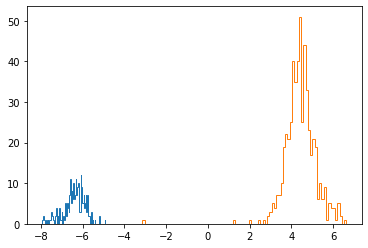

In [195]:
plt.hist(embedding(idx_flip.cuda()).cpu().detach().numpy(), bins=90, histtype='step');
plt.hist(embedding(idx_clean.cuda()).cpu().detach().numpy(), bins=90, histtype='step');

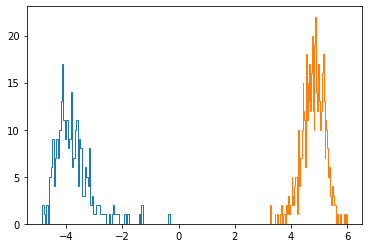

In [196]:
# plt.hist(embedding3(idx_flip.cuda()).cpu().detach().numpy(), bins=90, histtype='step');
# plt.hist(embedding3(idx_clean.cuda()).cpu().detach().numpy(), bins=90, histtype='step');

idx_map_flip = map_idxs(idx_flip.cuda(), GRID_SIZE_Y, GRID_SIZE_X)
idx_map_clean = map_idxs(idx_clean.cuda(), GRID_SIZE_Y, GRID_SIZE_X)

# mask_flip_idxs = torch.nn.functional.interpolate(x_or_intersect[idx_flip].unsqueeze(1).float(), size=(GRID_SIZE_Y, GRID_SIZE_Y)).squeeze(1).bool()
# masked_flipped_weights =  embedding4(idx_map_flip).view(-1,GRID_SIZE_Y, GRID_SIZE_X)[mask_flip_idxs]

# mask_flip_idxs = torch.nn.functional.interpolate(or_intersect[idx_flip].unsqueeze(1).float(), size=(GRID_SIZE_Y, GRID_SIZE_Y), mode='nearest').squeeze(1).float() # TODO best so far
# masked_flipped_weights =  embedding4(idx_map_flip).view(-1,GRID_SIZE_Y, GRID_SIZE_X) * mask_flip_idxs


mask_clean_idxs = or_intersect[idx_clean].float()
masked_clean_weights =  torch.nn.functional.interpolate(embedding4(idx_map_clean).view(-1,1,GRID_SIZE_Y, GRID_SIZE_X), size=(mask_clean_idxs.shape[-2:]), mode='bilinear', align_corners=True).squeeze(1) * mask_clean_idxs
masked_clean_weights[masked_clean_weights==0.] = float('nan')

mask_flip_idxs = or_intersect[idx_flip].float()
masked_flipped_weights =  torch.nn.functional.interpolate(embedding4(idx_map_flip).view(-1,1,GRID_SIZE_Y, GRID_SIZE_X), size=(mask_flip_idxs.shape[-2:]), mode='bilinear', align_corners=True).squeeze(1) * mask_flip_idxs
masked_flipped_weights[masked_flipped_weights==0.] = float('nan')
    
plt.hist(np.nanmean(masked_flipped_weights.detach().cpu(), axis=(-2,-1)), bins=90, histtype='step');  
plt.hist(np.nanmean(masked_clean_weights.detach().cpu(), axis=(-2,-1)), bins=90, histtype='step');      
# plt.hist((masked_flipped_weights).cpu().detach().numpy(), bins=90, histtype='step');

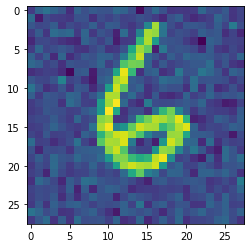

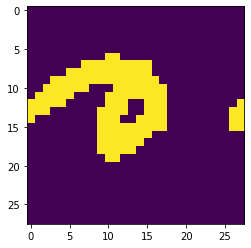

-6.444603443145752 10.499109268188477 2.875709056854248


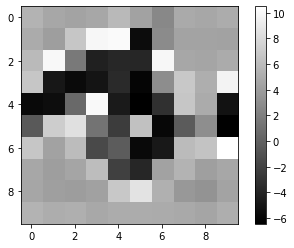

In [197]:
SHOW_IDX = 10
# plt.imshow(x_or_intersect[idx_flip[SHOW_IDX]].squeeze(0).cpu())
# plt.show()
plt.imshow(image[idx_flip[SHOW_IDX]].squeeze(0).cpu())
plt.show()
plt.imshow(segment[idx_flip[SHOW_IDX]].cpu())
plt.show()
show_weight = embedding4.weight[map_idxs(idx_flip[SHOW_IDX], GRID_SIZE_Y, GRID_SIZE_X)].view(-1,GRID_SIZE_Y,GRID_SIZE_X).unsqueeze(0)
# show_weight = torch.nn.functional.interpolate(show_weight, size=(28,28), mode='bilinear', align_corners=True).squeeze(1)

show_weight = show_weight.squeeze(0).squeeze(0)
print(show_weight.min().item(), show_weight.max().item(), show_weight.mean().item())
plt.imshow(show_weight.detach().cpu(), cmap='gray')
plt.colorbar()
plt.show()

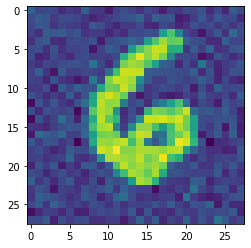

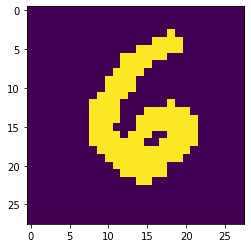

-1.9161736965179443 7.347299098968506 4.225479602813721


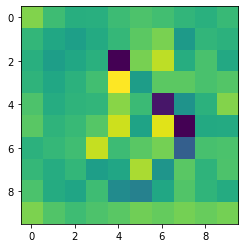

In [198]:
SHOW_IDX = 9
plt.imshow(image[idx_clean[SHOW_IDX]].squeeze(0).cpu())
plt.show()
plt.imshow(segment[idx_clean[SHOW_IDX]].cpu())
plt.show()
show_weight = embedding4.weight[map_idxs(idx_clean[SHOW_IDX], GRID_SIZE_Y, GRID_SIZE_X)].view(-1,GRID_SIZE_Y,GRID_SIZE_X).unsqueeze(0)
# show_weight = torch.nn.functional.interpolate(show_weight, size=(28,28), mode='bilinear', align_corners=True).squeeze(1)
    
show_weight = show_weight.squeeze(0).squeeze(0)
print(show_weight.min().item(), show_weight.max().item(), show_weight.mean().item())
plt.imshow(show_weight.detach().cpu())
plt.show()